### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder as enc
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
# Data Wrangling is Fun! :) 

### Merge datasets

In [2]:
#creating a new dataframe to store the merged csv files
data = pd.DataFrame()
FILEPATH = "/course/data/a2/games/"
filenames = ['NAmatch.csv', 'KRmatch.csv', 'EUmatch.csv']

all_datasets = []
for filename in filenames:
    all_datasets.append(pd.read_csv(FILEPATH + filename))

merged_data = pd.concat(all_datasets)

## 1. Pre-processing

### Filter values relevant to research

In [3]:
#limit roles to only top lane and jungle
filtered_data = merged_data[merged_data['role'] == 'TopLane_Jungle']

#only use data from champions which have been played more than the mean times played to reduce outliers
times_played = filtered_data.groupby('champion').size()
used_champions = times_played[times_played >= times_played.mean()].index
boolean_series = filtered_data.champion.isin(used_champions)
filtered_data = filtered_data[boolean_series]

#remove columns not relevant to the research
filtered_data = filtered_data.drop(columns=['d_spell', 'f_spell', 'champion', 'side', 'role'])
filtered_data = filtered_data.reset_index(drop=True)

### Fill in missing values

In [4]:
numeric_features = filtered_data.columns[:-1]
feature_means = {}

#find mean value of each numeric feature
for feature in numeric_features:
    feature_means[feature] = float(f'{filtered_data[feature].mean():.1f}')

#replace numeric features with missing values, with their respective means
for feature in filtered_data[numeric_features]:
    filtered_data[feature] = filtered_data[feature].replace(np.nan, feature_means[feature])

## 2. Feature selection

### Normalize dataset

In [5]:
#ordinalize minions_killed
ordinalized_minions = enc().fit_transform(filtered_data[['minions_killed']])
filtered_data['minions_killed'] = ordinalized_minions

In [6]:
#normalize the dataset for feature selection
normalized_data = (filtered_data-filtered_data.min())/(filtered_data.max()-filtered_data.min())

### Feature selection by mutual information

In [7]:
filtered_features = []
class_label = normalized_data['damage_total']
features = normalized_data.drop(columns=['damage_total'])

# threshold mutual information level for accepting / rejecting features
THRESHOLD = 0.3

mi_arr = mutual_info_regression(X=features, y=class_label, discrete_features=False)
for feature, mi in zip(features.columns, mi_arr):
    if(mi >= THRESHOLD): 
        filtered_features.append(feature)
        print(f'MI value for feature "{feature}": {mi:.4f}')

print('\nFeature set after filtering with MI:', filtered_features)
filtered_data_columns = filtered_features + ['damage_total']

# filter data such that only filtered features will be considered
filtered_data = filtered_data[filtered_data_columns]

MI value for feature "damage_building": 0.3934
MI value for feature "level": 0.6337
MI value for feature "damage_taken": 0.3320
MI value for feature "gold_earned": 0.8430

Feature set after filtering with MI: ['damage_building', 'level', 'damage_taken', 'gold_earned']


## 3. Train-Test Split


In [8]:
#split the data into training and testing sets
train, test = train_test_split(filtered_data, shuffle=True)

### Discretization

In [9]:
#functions to ordinalize and discretize numeric features, based on a given lower boundary and
#upper boundary

def ordinalize_features(value, lower_bound, upper_bound):
    if value >= upper_bound:
        return 2
    elif value >= lower_bound:
        return 1
    else:
        return 0

def discretize_dmg_total(value, lower_bound, upper_bound):
    if value >= upper_bound:
        return "high"
    elif value >= lower_bound:
        return "mid" 
    else:
        return "low"

In [10]:
"""Assume all the numeric features follow a normal distribution. Since we are discretizing and
ordinalizing all the features into 3 levels, for each feature:
"low" (0): value < mean-stdev
"mid" (1): mean-stdev <= value <= mean+stdev
"high" (2): value > mean+stdev"""

categorized_data = pd.DataFrame()

# ordinalize features
for column in filtered_features:
    stdev = train[column].std()
    mean = train[column].mean()
    label_bins = [mean-stdev, mean+stdev]
    categorized_data[column] = filtered_data[column].apply(ordinalize_features, args=(label_bins))

# discretize damage_total
stdev = train['damage_total'].std()
mean = train['damage_total'].mean()
label_bins = [mean-stdev, mean+stdev]
categorized_data['damage_total'] = filtered_data['damage_total'].apply(discretize_dmg_total, args=(label_bins))

# discretized and ordinalize training and test sets
x_vals = categorized_data[filtered_features]
y_vals = categorized_data['damage_total']

x_train = x_vals.iloc[train.index]
y_train = y_vals.iloc[train.index]

x_test = x_vals.iloc[test.index]
y_test = y_vals.iloc[test.index]

## 4. Decision Tree

### Find best decision tree depth

In [11]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

depth=[]
for i in range(3,11):
    dt_model = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(estimator=dt_model, X=x_train, y=y_train, cv=kf)
    depth.append((i, scores.mean()))

best_depth = max(depth, key=lambda item:item[1])[0]
print("Best tree depth:", best_depth)

Best tree depth: 6


### Fit decision tree

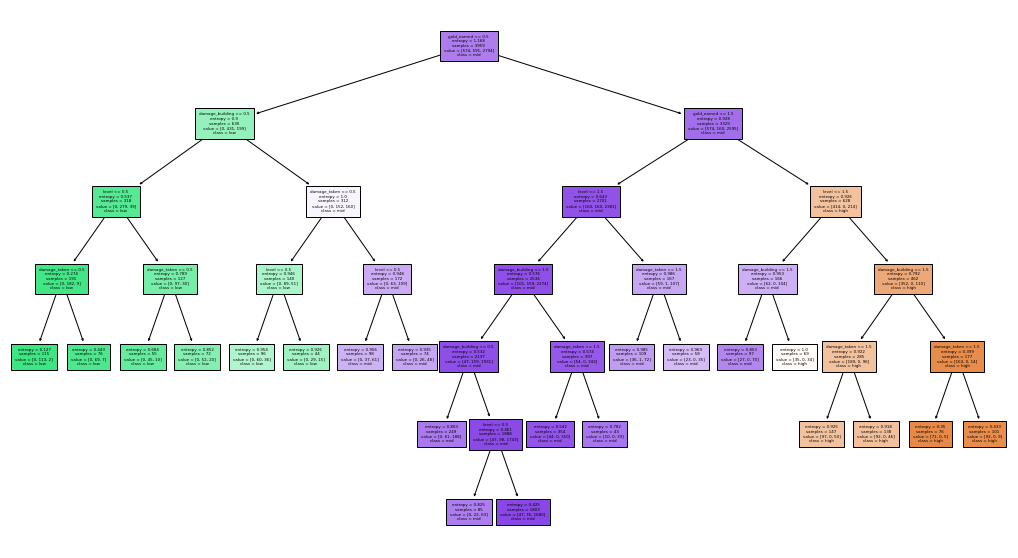

In [12]:
min_samples_leaf = int(len(x_train)*0.01)
decision_tree = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=min_samples_leaf, criterion='entropy')
decision_tree.fit(x_train, y_train)

dt_pred = decision_tree.predict(x_test)
dt_accuracy = decision_tree.score(x_test, y_test)

fig, axes = plt.subplots(figsize=(18,10))
plot_tree(decision_tree, # the DT classifier
          feature_names=filtered_features, # feature names
          class_names=decision_tree.classes_, # class labels
          filled=True, # fill in the rectangles
          ax = axes,
          fontsize=4
         )

plt.savefig("dt.pdf")
plt.show()

### Evaluating Decision Tree model

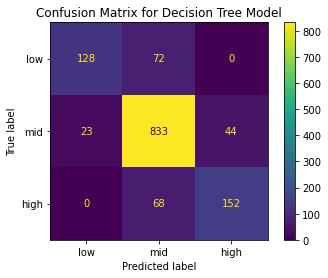

Accuracy: 0.8431818181818181
f1: 0.7831986914563887


In [13]:
cm_dt = confusion_matrix(y_test, dt_pred, labels=["low", "mid", "high"])
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["low", "mid", "high"])

cm_disp.plot()

plt.title("Confusion Matrix for Decision Tree Model")
plt.savefig("cm_dt.jpg")
plt.show()

f1 = f1_score(y_test, dt_pred, average="macro")
print(f"Accuracy: {dt_accuracy}")
print(f"f1: {f1}")

## 5. k-Nearest Neighbours


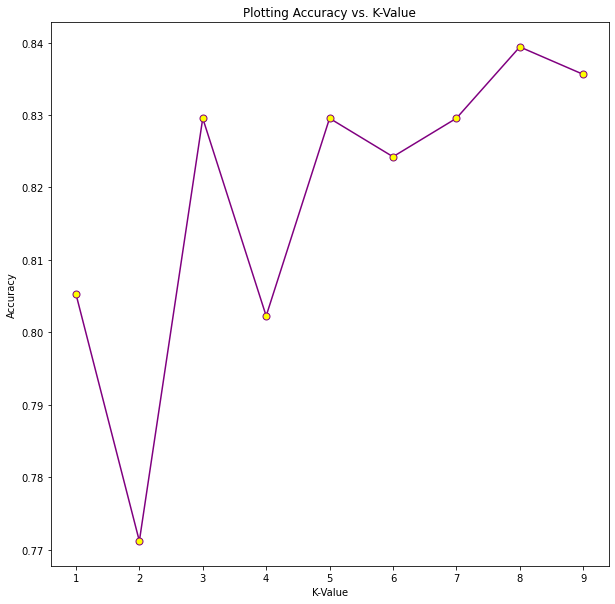

Best accuracy: 0.8393939393939394 at K= 8


In [14]:
#calculating the acuracy of the model at different k-values
accuracy_lst = []

for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train,y_train)
    y_pred = knn.predict(x_test)
    accuracy_lst.append(knn.score(x_test, y_test))

#calculating the best accuracy at which k-value
best_accuracy = max(accuracy_lst)   
best_k_val = accuracy_lst.index(best_accuracy) + 1

#plotting it onto a graph
plt.figure(figsize=(10,10))
plt.plot(range(1,10), accuracy_lst, color = 'purple', linestyle='solid', marker='o',markerfacecolor='yellow', markersize=7)
plt.title('Plotting Accuracy vs. K-Value')
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.savefig("acc_vs_kval.jpg")
plt.show()

#printing the best accuracy and k-value
print("Best accuracy:", best_accuracy, "at K=", best_k_val)

### Evaluating k-NN model

In [15]:
#creating the final knn model to be used on the data
final_knn = KNeighborsClassifier(n_neighbors = best_k_val)
final_knn.fit(x_train,y_train)
y_pred = final_knn.predict(x_test)

#evaluating the accuracy and f1 of the model
accuracy = final_knn.score(x_test, y_test)
f1 = f1_score(y_test, y_pred, average="macro")

print('Accuracy:', best_accuracy)
print('f1:', f1)

Accuracy: 0.8393939393939394
f1: 0.7868247787524599


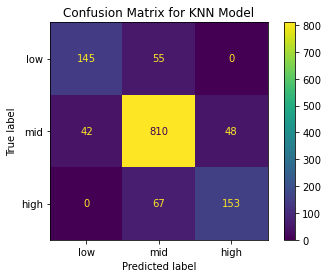

In [16]:
#creating a confusion matrix to evaluate the model
cm = confusion_matrix(y_test, 
                      y_pred, 
                      labels=["low", "mid", "high"]
                     )

#visualising the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["low", "mid", "high"]
                             )

disp.plot()

plt.title("Confusion Matrix for KNN Model")
plt.savefig("cm_knn.jpg")
plt.show()